# Neural Style Transfer

Neural style transfer is an optimization technique used to take two images a *content* image and a *style reference* image and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.


## Code

In [ ]:
import tensorflow as tf

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

**Provide links to download content and style images:**

In [ ]:
content_url = 'https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg'  # @param {type:"string"}
style_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}

content_path = tf.keras.utils.get_file('content.jpg', content_url)
style_path = tf.keras.utils.get_file('style.jpg', style_url)


3170828/3170828 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2684586/2684586 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Function to load an image and limit its maximum dimension to 1024 pixels:**

In [ ]:
def load_img(path_to_img):
  max_dim = 1024
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

**Function to show image:**

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

**Show content and style image to user:**

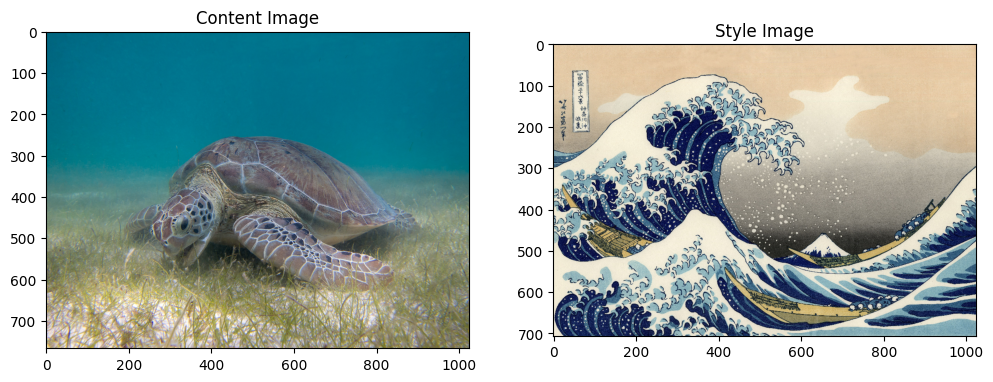

In [ ]:

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

**Loading `VGG19` and listing all the layers:**

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


**Choose intermediate layers from the network to represent the style and content of the image:**

In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

**Function to create a VGG19 model that returns a list of intermediate layer outputs:**

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

**Creating the model and printing the statistics of each layer's output:**

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)  # doubt

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 706, 1024, 64)
  min:  0.0
  max:  801.23846
  mean:  33.040382

block2_conv1
  shape:  (1, 353, 512, 128)
  min:  0.0
  max:  4761.3296
  mean:  198.44243

block3_conv1
  shape:  (1, 176, 256, 256)
  min:  0.0
  max:  9355.588
  mean:  184.36519

block4_conv1
  shape:  (1, 88, 128, 512)
  min:  0.0
  max:  21500.398
  mean:  713.1662

block5_conv1
  shape:  (1, 44, 64, 512)
  min:  0.0
  max:  3656.9746
  mean:  51.96477



**Function to calculate the Gram matrix:**

 This includes the information of style of the image which is described by the means and correlations across the different feature maps. This can be implemented concisely using the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

**Model to return the style and content tensors:**

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

**Return the Gram matrix (style) of the `style_layers` and (content) of the `content_layers`:**

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.029505951
    max:  26888.5
    mean:  771.66626

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  96588.64
    mean:  11505.065

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  202128.3
    mean:  7758.7915

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3019857.5
    mean:  98005.18

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  38357.824
    mean:  484.57562

Contents:
   block5_conv2
    shape:  (1, 47, 64, 512)
    min:  0.0
    max:  1120.1232
    mean:  7.080744


**Gradient Descent**

Calculate the mean square error for image's output relative to each target, then take the weighted sum of these losses.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize:

In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an `Adam` Optimizer:

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image by minimizing the loss.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

**Training the model using above optimization:**

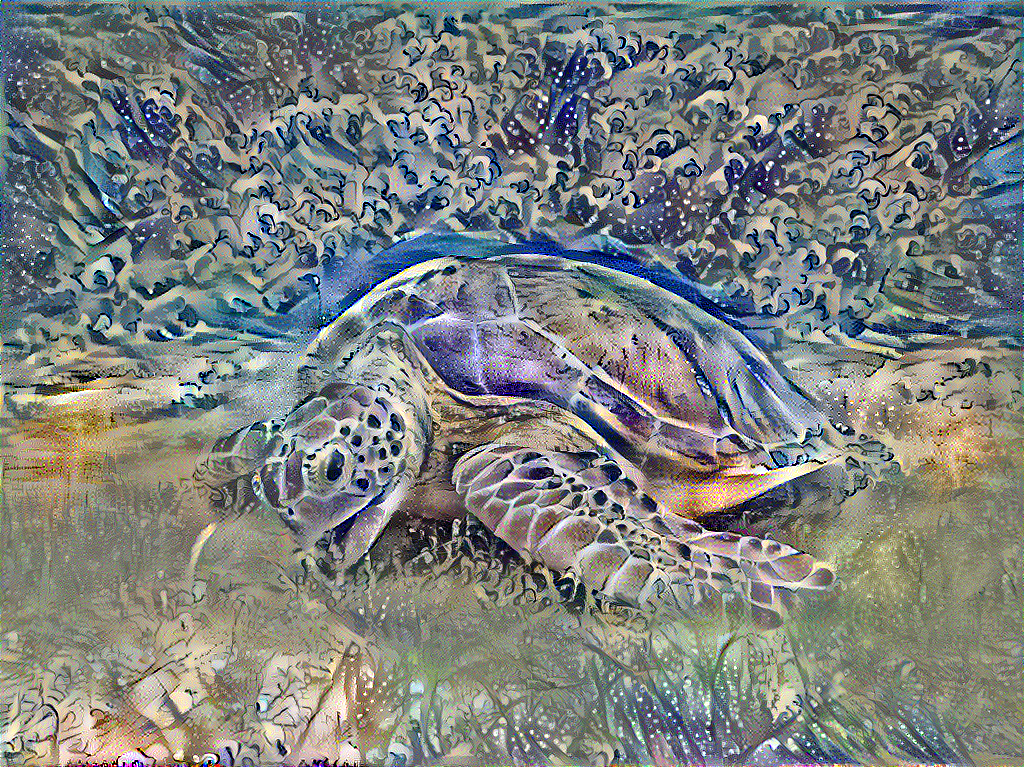

Train step: 1000
Total time: 286.8


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))